# A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import set_config
from kneed import KneeLocator




# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')
# 
# Graphing helper
# 
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

# Load the dataset

In [2]:
df = pd.read_csv("./bank.csv")
print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


# B. Exploratory Data Analysis and Data Preparation¶

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [4]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28.0,admin.,single,secondary,no,127,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81.0,retired,married,primary,no,1154,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46.0,services,married,primary,no,4343,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40.0,entrepreneur,married,secondary,no,6403,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,1823.000000,11.000000,854.000000,55.000000


balance and pdays has negative values

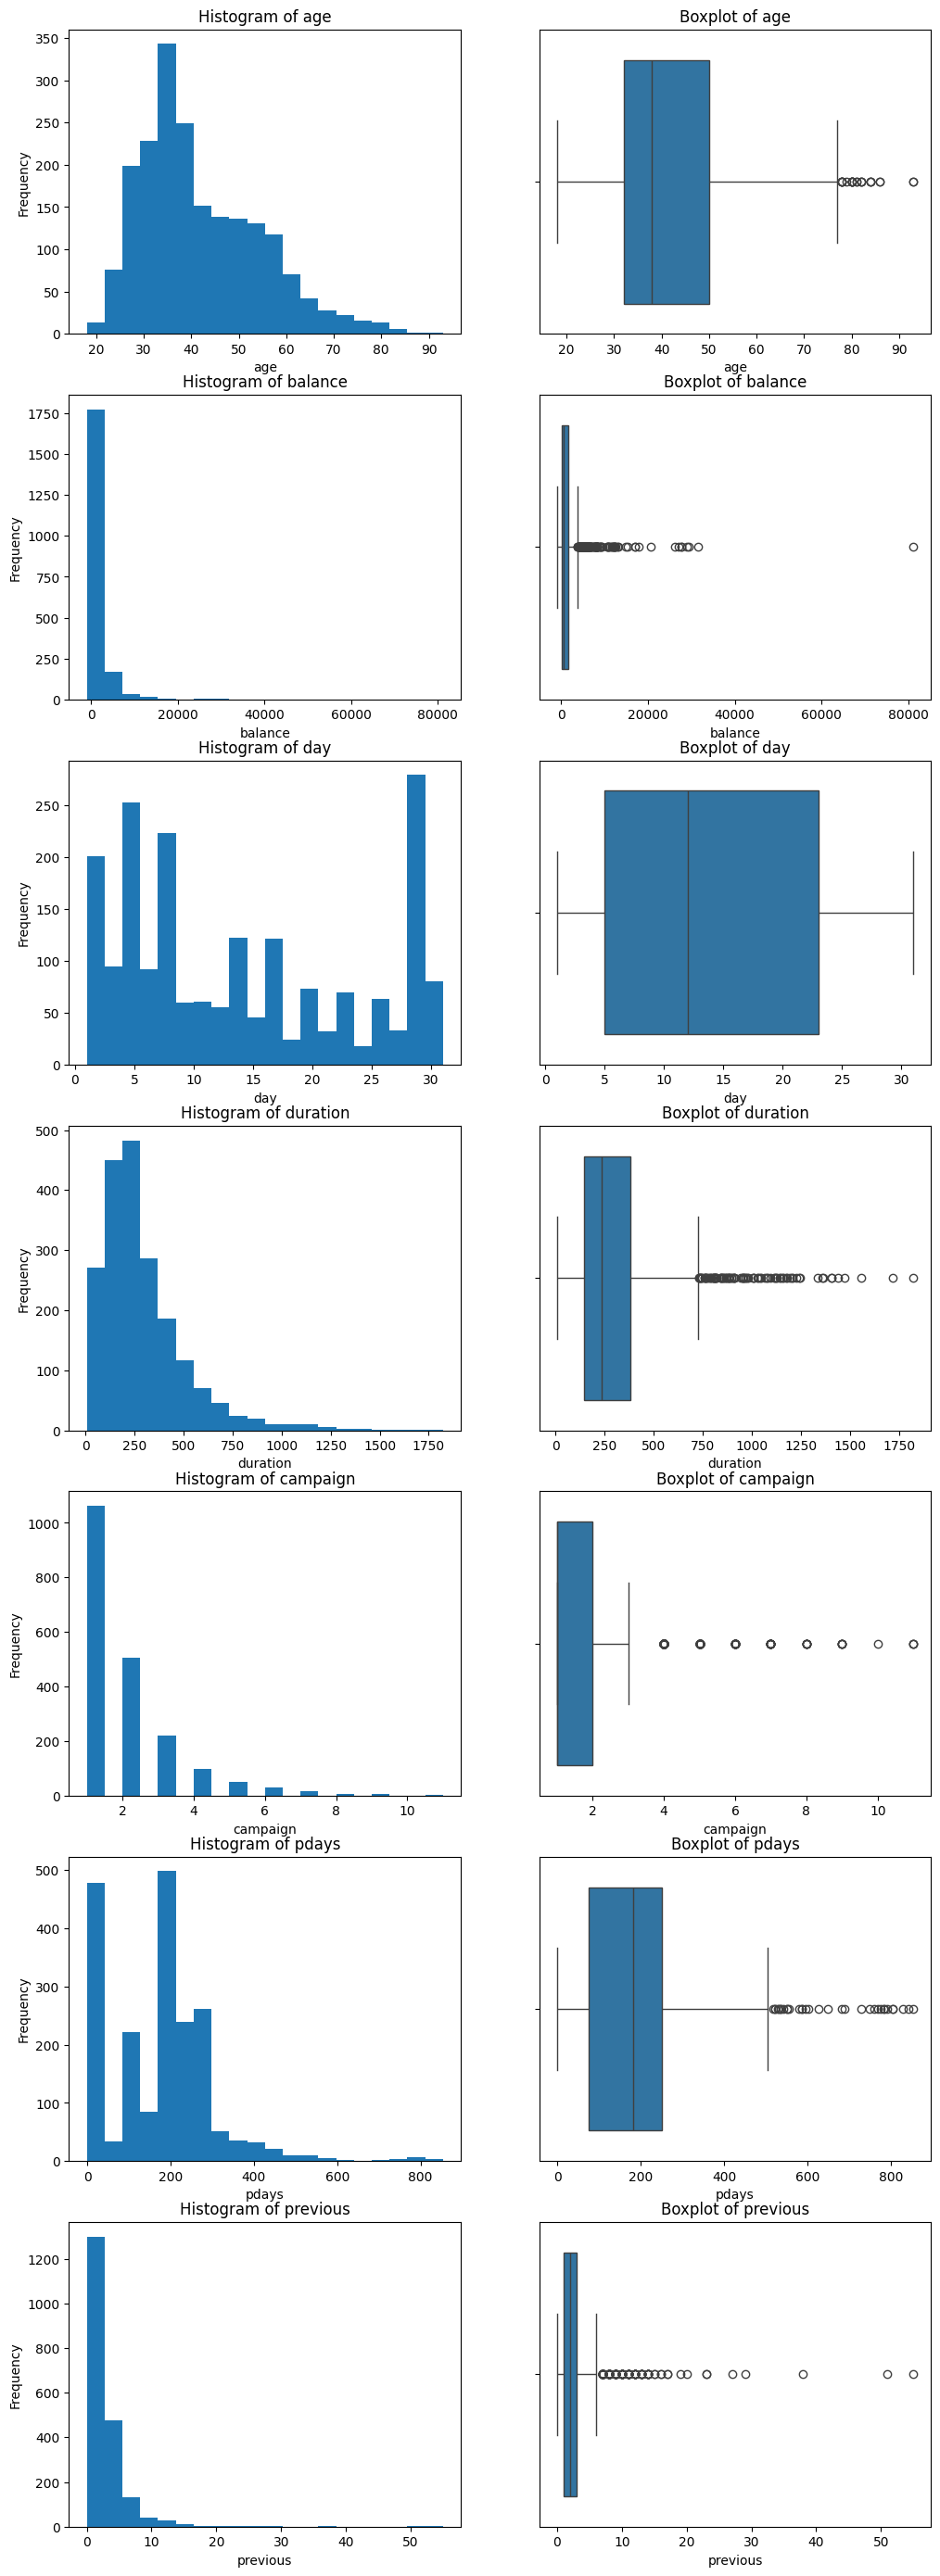

In [6]:
cols = ['age','balance','day','duration','campaign','pdays','previous']

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12,35))    

for row, column in enumerate(cols):

    axes[row,0].hist(df[column], bins=20)
    axes[row,0].set_title(f'Histogram of {column}')
    axes[row,0].set_xlabel(column)
    axes[row,0].set_ylabel('Frequency')

    # Put boxplot in 2nd col
    sns.boxplot(data=df, x=column, ax=axes[row][1])
    
    axes[row,1].set_title(f'Boxplot of {column}')
    axes[row,1].set_xlabel(column)

plt.show()


**Everything except day has outliers and seems right skewed, so**
1. Use Minmaxscaler for days as its a known range
1. Use RobustScalar for others as they've outliers
1. 

# Task 1: Data Preparation Pipeline

## Drop columns that we don't want to avoid data leakage

In [7]:
# Drop columns that we don't want to avoid data leakage
df.drop(columns=['duration'], inplace=True) 
df.drop(columns=['subscribed'], inplace=True) 


In [8]:
## Encode Ordinal Features

### Education

In [9]:
# Create a dictionary for education

education_dictionary = {
    "primary" : 0,
    "secondary" : 1,
    "tertiary" : 2
}

df['education'] = df['education'].replace(education_dictionary)
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,2,-1,0,NaN
1996,28.0,admin.,single,1,no,127,no,no,cellular,16,sep,2,-1,0,NaN
1997,81.0,retired,married,0,no,1154,no,no,telephone,17,sep,1,-1,0,NaN
1998,46.0,services,married,0,no,4343,yes,no,NaN,20,sep,1,-1,0,NaN
1999,40.0,entrepreneur,married,1,no,6403,no,no,cellular,22,sep,2,-1,0,NaN


### Month

In [10]:
# Create a dictionary for month
calendar_dict = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6,
                  'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}

df['month'] = df['month'].replace(calendar_dict)
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,9,2,-1,0,NaN
1996,28.0,admin.,single,1,no,127,no,no,cellular,16,9,2,-1,0,NaN
1997,81.0,retired,married,0,no,1154,no,no,telephone,17,9,1,-1,0,NaN
1998,46.0,services,married,0,no,4343,yes,no,NaN,20,9,1,-1,0,NaN
1999,40.0,entrepreneur,married,1,no,6403,no,no,cellular,22,9,2,-1,0,NaN


## Deal with Zero or negative values
The data has negative values.  Add a delta to attributes with a negative value, to make them positive.

In [11]:
df.describe()

,age,balance,day,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,11.000000,854.000000,55.000000


In [12]:
# get min values for attributes
columns = ['balance','pdays','previous']


for col in columns:
    shift_value = abs(df[col].min()) + 2  # Ensures no negative or zero
    df[col] = np.log(df[col] + shift_value)

df.describe()


,age,balance,day,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,7.511862,13.851500,1.909500,4.229232,1.357902
std,12.724358,0.647772,9.712189,1.378862,1.983043,0.527848
min,18.000000,0.693147,1.000000,1.000000,0.693147,0.693147
25%,32.000000,7.076231,5.000000,1.000000,4.366263,1.098612
50%,38.000000,7.334982,12.000000,1.000000,5.220356,1.386294
75%,50.000000,7.873407,23.000000,2.000000,5.537334,1.609438
max,93.000000,11.316740,31.000000,11.000000,6.753438,4.043051


### Check for Missing Values

In [13]:
print(df.dtypes)

age          float64
job           object
marital       object
education     object
default       object
balance      float64
housing       object
loan          object
contact       object
day            int64
month         object
campaign       int64
pdays        float64
previous     float64
poutcome      object
dtype: object


In [14]:
### Check for missing values.  .sort_values(ascending=False)
print ('number of values missing for column')
df.isna().sum()[df.isna().sum() > 0].sort_index(ascending=True)



number of values missing for column


age           12
contact      191
education    104
job           10
poutcome     454
dtype: int64

### Imput Poutcome
From the first assignment, we decided to set nulls here to not_contacted.

In [15]:
# Looks like poutcome won't be filled out if they haven't been contacted before, which is reasonable.  For these rows, imput not_contacted
df['poutcome']=df['poutcome'].fillna('not_contacted')


## Create Imput Missing Values Pipeline
1. Use Median for age
1. Use Mode for Education, Contact and Job
1. Add constant string, NOT_CONTACTED for poutcome

right skewed attributes were age','balance','duration','pdays','previous

### Pipeline Approach
|Type| Attribute    | Imput | Scale| One Hot Encode|Comment|
|-----|-------------|-----|------------|--------|----|
|Numerical| age   | most_frequent  | Robust   |||
|Numerical| balance     |  | Robust  |||
|Categorical| campaign |   | Robust    |||
|Categorical| contact   | most_frequent  | |Yes   ||
|| day     |   | MinMaxScaler  |||
|Categorical| default |  |  |Yes||
|Categorical-Ordinal| education   | most_frequent  |    |Yes|Used Mapper above to transform to ordinal|
|Categorical| housing     |  |  |Yes||
|Categorical| job | most_frequent  |  |Yes||
|Categorical| loan   |   |    |Yes||
|Categorical| marital     |  |  |Yes||
|Categorical-Ordinal| month |   | MinMaxScaler    ||Used Mapper above to transform|
|Numerical| pdays     |   | Robust  |||
|Categorical| poutcome | Done outside pipeline  |     |Yes|Manually Imput NOT_CONTACTED for N/As above, perhaps use MissingIndicator Imputter |
|Numerical| previous |   | Robust    |||numerical_attribute_scale_using_robust

In [16]:
numerical_attribute = ['age','balance','day','pdays','previous']
numerical_attribute_scale_using_min_max = ['day']
numerical_attribute_scale_using_robust=['age','balance','pdays','previous']

categorical_attribute = ['campaign','contact','default','education','housing','job','loan','marital','month','poutcome']


num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', ColumnTransformer(
                transformers=[
                        ('scale_using_min_max',MinMaxScaler(),numerical_attribute_scale_using_min_max),
                        ('scale_using_robust',RobustScaler(),numerical_attribute_scale_using_robust)
                        ]
                )
    )
    ]
)

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(sparse_output=False)) # sparse output required for fit_transform
])

col_transform = ColumnTransformer(transformers=[
        ('num_pipeline',num_pipeline,numerical_attribute),
        ('cat_pipeline',cat_pipeline,categorical_attribute)
    ], remainder='drop', n_jobs=-1)



preprocess_pipeline = Pipeline(steps=[
    ('preprocess', col_transform), 
    
])

In [17]:

df_post_col_transform = preprocess_pipeline.fit_transform(df)
#clustering_model = preprocess_pipeline.fit(df)

#('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
#df_post_col_transform.head()

# Task 2: k-Means

### Plot the sum of squared distances from the data points in the prepared bank dataset to the centers of the k-Means clusters for various values of k and use the Elbow method to pick the best value of k.

#### Elbow Method

Optimal number of clusters (k): 2


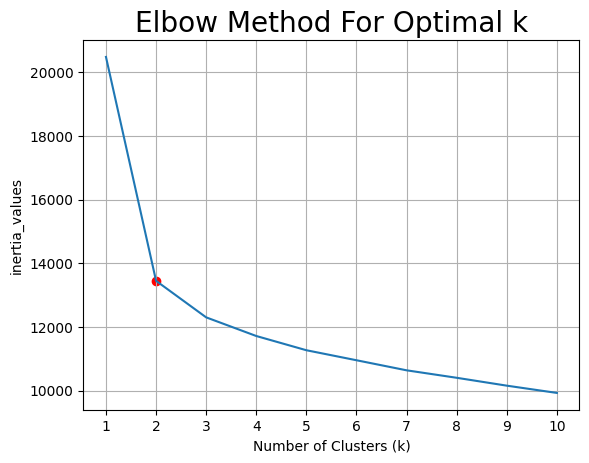

In [18]:
# Interia is the sum of the squared distance of the point and its centroid
inertia_values = []

# KMeans args
#  n_clusters : The number of clusters to form as well as the number of centroids to generate.
# ‘k-means++’ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia
# max_iter : iterations per run
# n_init : Number of times the k-means algorithm is run with different centroid seeds
# random_state : Determines random number generation for centroid initialization

#
#
# Loop through a range of k values (1 to 10 for example)
for k in range(1, 11):

 
    model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    model.fit(df_post_col_transform)  # Fit the k-Means model
    
    inertia_values.append(model.inertia_)  # Inertia is the sum of squared distances

kl = KneeLocator(range(1, 11), inertia_values, curve="convex", direction="decreasing" )

print(f"Optimal number of clusters (k): {kl.elbow}")

# Plotting the Elbow Method graph
plt.plot(range(1, 11), inertia_values)
plt.xticks(range(1, 11))
plt.scatter(kl.elbow, inertia_values[kl.elbow - 1], color='red', label='Elbow')
plt.style.use("fivethirtyeight")
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('inertia_values')
plt.grid(True)
plt.show()


#### Silhouette Coefficient

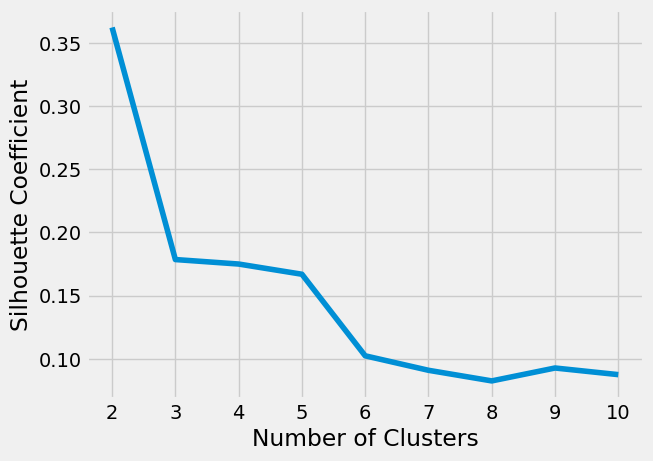

Optimal number of clusters (k) based on Silhouette Score: 2


In [19]:
silhouette_coefficients = []
 
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    
    model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    model.fit(df_post_col_transform)  # Fit the k-Means model
    
    score = silhouette_score(df_post_col_transform, model.labels_)
    
    silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

# Print the best k with the highest silhouette score
best_k = range(2, 11)[silhouette_coefficients.index(max(silhouette_coefficients))]

print(f"Optimal number of clusters (k) based on Silhouette Score: {best_k}")

#### Use the best value(s) of k to cluster the prepared bank dataset with k-means. Aim at producing meaningful clustering.
The Elbow and Silhouette score suggests 2 is the best value for k.  

In [20]:
best_k = 2


model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
model.fit(df_post_col_transform)  # Fit the k-Means model
#
#clustering_model = pipe.fit_transform(df)

# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = df_post_col_transform
preprocessed_data

# Append the cluster centers to the preprocessed dataset.
data_and_centers = np.r_[preprocessed_data,model.cluster_centers_]



transformation complete


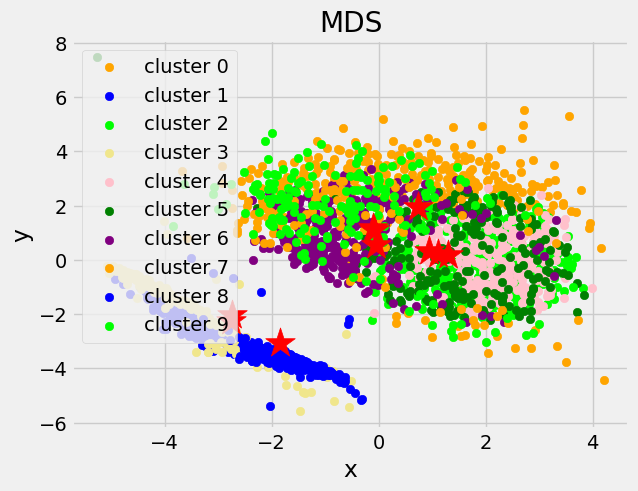

In [21]:
# Project both the data and the k-Means cluster centers to 2D.
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
print("transformation complete")

clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=model.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")


clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=model.labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')



#### Use MDS and t-SNE for visualising the clusterings. Write a short conclusion about the characteristics of the clusters 

In [ ]:
df['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)

# DBSCAN

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10).fit(df_post_col_transform)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

#plt.scatter(df_post_col_transform.iloc[:, 0], df_post_col_transform.iloc[:, 1], c=labels, cmap='viridis')
#plt.title('DBSCAN Clustering')
#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
#plt.show()

#print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
#print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
#print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
#print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
#print(
#    "Adjusted Mutual Information:"
#    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
#)
#print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

# D. K-Means Clustering
The k-Means clustering algorithm has the number of clusters, k, as an input parameter n_clusters. 
We construct a final pipeline for training a k-Means clustering model for a fixed value of n_clusters = 3. 
The final pipeline has the preprocessing pipeline as its first step followed by the scikit-learn KMeans algorithm as a second step.

In [ ]:
k = 3

pipe = Pipeline(steps=[
    ('preprocess', col_transform), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])

Next, we fit the pipeline on the dataset to train a clustering model.

In [ ]:
clustering_model = pipe.fit(df)

In [ ]:
# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model['preprocess'].transform(df)
preprocessed_data

# E. Apply a manifold-learning technique to project the data set to a 2D space
Append the cluster centers to the preprocessed dataset.

In [ ]:
data_and_centers = np.r_[preprocessed_data,clustering_model['kMeans'].cluster_centers_]

# E1. Apply multi-dimensional scaling (MDS) to project both the data and the k-Means cluster centers to a 2D space
Project both the data and the k-Means cluster centers to 2D.

In [ ]:
XYcoordinates = manifold.MDS(n_components=2, normalized_stress='auto').fit_transform(data_and_centers)
print("transformation complete")


In [ ]:
XYcoordinates = manifold.TSNE(n_components=2).fit_transform(data_and_centers)
print("transformation complete")

Plot the transformed examples and the centers. Use the cluster assignment to colour the examples

In [ ]:

clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')


# E2. Apply t-SNE to project both the data and the k-Means cluster centers to a 2D space
Project both the data and the k-Means cluster centers to 2D.

In [ ]:

clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustering_model['kMeans'].labels_,
                       centers=XYcoordinates[-k:,:], 
                       title='TSNE')

In [ ]:
df['cluster'] = pd.Series(clustering_model['kMeans'].labels_, index=df.index)

df.head()

df.tail()

df.groupby('cluster')

#
# for debug save intermediate state
# 

df.tail()
transformed_df = pd.DataFrame(df)
transformed_df.to_csv('before_transformed_data.csv', index=False)

transformed_df.tail();

df.describe();

In [ ]:


#preprocess_pipeline
X_debug = col_transform.fit_transform(df)
print ('debug',X_debug);

#.toarray(), columns=pipeline.named_steps['onehot'].get_feature_names_out(['contact'])
transformed_df = pd.DataFrame(X_debug)

# Save the transformed data to a CSV file
transformed_df.to_csv('transformed_data.csv', index=False)



clustering_model = pipe.fit(df)

# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model['preprocess'].transform(df)

Misc Workings